In [1]:
!pip install spacy kagglehub pandas numpy matplotlib seaborn

In [2]:
# Cell 1: Import required libraries and load the actual dataset
import spacy
from spacy import displacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import os
import gzip
import shutil

# Initialize spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model...")
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

In [3]:
# Cell 2: Load the actual Amazon reviews dataset from KaggleHub
def load_actual_amazon_reviews():
    """Load the actual Amazon reviews dataset from KaggleHub"""
    print("Loading Amazon reviews dataset from KaggleHub...")
    
    try:
        # Download the dataset
        import kagglehub
        path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
        print(f"Dataset downloaded to: {path}")
        
        # Look for the data files
        data_files = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.csv') or file.endswith('.txt') or file.endswith('.gz'):
                    data_files.append(os.path.join(root, file))
        
        print(f"Found data files: {data_files}")
        
        # Try to read the data - this dataset typically contains gzipped files
        reviews = []
        for file_path in data_files:
            try:
                if file_path.endswith('.gz'):
                    # Handle gzipped files
                    with gzip.open(file_path, 'rt', encoding='utf-8', errors='ignore') as f:
                        # Read first few lines to understand structure
                        for i, line in enumerate(f):
                            if i >= 1000:  # Limit for demonstration
                                break
                            reviews.append(line.strip())
                elif file_path.endswith('.csv'):
                    # Handle CSV files
                    df_chunk = pd.read_csv(file_path, nrows=1000)
                    if 'review' in df_chunk.columns:
                        reviews.extend(df_chunk['review'].astype(str).tolist())
                    elif 'text' in df_chunk.columns:
                        reviews.extend(df_chunk['text'].astype(str).tolist())
                    else:
                        # Use first column as review text
                        reviews.extend(df_chunk.iloc[:, 0].astype(str).tolist())
                elif file_path.endswith('.txt'):
                    # Handle text files
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        for i, line in enumerate(f):
                            if i >= 1000:
                                break
                            reviews.append(line.strip())
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
        
        # If we couldn't load from the actual dataset, create meaningful sample data
        if not reviews:
            print("Creating sample reviews based on common Amazon review patterns...")
            reviews = [
                "The Apple iPhone 14 Pro Max is absolutely fantastic! The camera quality is outstanding and battery life lasts all day. Worth every penny of the $999 price.",
                "Samsung Galaxy S23 Ultra disappointed me. The battery drains too quickly and the phone overheats with normal use. Not recommended.",
                "Sony WH-1000XM4 headphones have incredible noise cancellation. Best purchase I made this year from Amazon for $349.",
                "Amazon Echo Dot 4th Gen is okay for basic tasks but the sound quality could be better. Alexa works well most of the time.",
                "Microsoft Surface Pro 9 is perfect for remote work. The performance is smooth and the design is sleek. Great product!",
                "Bose QuietComfort headphones broke after just 2 months. Very poor build quality. Customer service was unhelpful.",
                "Google Pixel 7 Pro takes amazing photos. The night mode is incredible and the Android experience is smooth.",
                "HP Pavilion laptop constantly crashes and has hardware issues. Bought from Best Buy but regret the purchase.",
                "Nintendo Switch OLED is fantastic for family gaming. The kids love Mario Kart and the display is beautiful.",
                "Dell XPS 13 is reliable for programming. Fast performance and good battery life. Recommended for developers.",
                "MacBook Air M2 chip is revolutionary! Lightweight yet powerful. Apple has done it again with this $1199 laptop.",
                "Lenovo ThinkPad is durable but the display quality is mediocre. Good for business but not for media consumption.",
                "PlayStation 5 delivers exceptional gaming experience. Graphics are amazing and loading times are super fast.",
                "Asus monitor has dead pixels right out of the box. Very frustrating experience with Amazon delivery.",
                "Canon EOS R5 produces professional quality photos. Worth the investment for serious photographers."
            ]
        
        # Create DataFrame with ratings
        ratings = [5, 1, 5, 3, 5, 1, 5, 2, 5, 4, 5, 3, 5, 1, 5]
        
        # If we have more reviews than ratings, extend ratings
        if len(reviews) > len(ratings):
            extended_ratings = ratings * (len(reviews) // len(ratings) + 1)
            ratings = extended_ratings[:len(reviews)]
        
        return pd.DataFrame({
            'review_text': reviews[:100],  # Limit to 100 reviews for performance
            'rating': ratings[:100]
        })
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Creating fallback sample data...")
        return create_fallback_data()

def create_fallback_data():
    """Create fallback sample data"""
    sample_reviews = [
        "The new iPhone from Apple is amazing! Camera quality is outstanding for $999.",
        "Samsung Galaxy has terrible battery life. Very disappointed with this purchase.",
        "Sony headphones have incredible noise cancellation. Best buy ever!",
        "Amazon Echo is okay but sound quality could be better.",
        "Microsoft Surface Pro works great for business meetings and remote work.",
        "Bose headphones broke quickly. Poor quality and bad customer service.",
        "Google Pixel camera is fantastic in low light conditions.",
        "HP laptop crashes constantly with blue screen errors.",
        "Nintendo Switch is perfect for family entertainment and gaming.",
        "Dell XPS is reliable for software development and coding projects."
    ]
    
    return pd.DataFrame({
        'review_text': sample_reviews,
        'rating': [5, 1, 5, 3, 4, 1, 5, 2, 5, 4]
    })

# Load the actual data
print(" Loading Amazon reviews dataset...")
reviews_df = load_actual_amazon_reviews()
print(f" Successfully loaded {len(reviews_df)} reviews")
print("\nFirst 3 reviews:")
for i, row in reviews_df.head(3).iterrows():
    print(f"Review {i+1}: {row['review_text'][:100]}... | Rating: {row['rating']}/5")

 Loading Amazon reviews dataset...
Loading Amazon reviews dataset from KaggleHub...
Download already complete (517080965 bytes).
Extracting files...
Error loading dataset: [Errno 28] No space left on device
Creating fallback sample data...
 Successfully loaded 10 reviews

First 3 reviews:
Review 1: The new iPhone from Apple is amazing! Camera quality is outstanding for $999.... | Rating: 5/5
Review 2: Samsung Galaxy has terrible battery life. Very disappointed with this purchase.... | Rating: 1/5
Review 3: Sony headphones have incredible noise cancellation. Best buy ever!... | Rating: 5/5


In [4]:
# Cell 3: Enhanced NER function for Amazon reviews
def extract_entities_spacy(text):
    """Extract named entities from Amazon reviews using spaCy"""
    doc = nlp(text)
    
    entities = {
        'PRODUCT': [],
        'BRAND': [],
        'ORG': [],
        'GPE': [],
        'MONEY': [],
        'DATE': [],
        'CARDINAL': []
    }
    
    # Extract standard entities
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)
    
    # Enhanced product and brand detection for Amazon context
    product_patterns = {
        'iphone': 'iPhone', 'galaxy': 'Galaxy', 'headphones': 'Headphones',
        'laptop': 'Laptop', 'camera': 'Camera', 'monitor': 'Monitor',
        'tablet': 'Tablet', 'phone': 'Phone', 'computer': 'Computer',
        'earbuds': 'Earbuds', 'echo': 'Echo', 'surface': 'Surface',
        'switch': 'Switch', 'pixel': 'Pixel', 'macbook': 'MacBook',
        'playstation': 'PlayStation', 'xbox': 'Xbox'
    }
    
    brand_patterns = {
        'apple': 'Apple', 'samsung': 'Samsung', 'sony': 'Sony',
        'amazon': 'Amazon', 'microsoft': 'Microsoft', 'bose': 'Bose',
        'google': 'Google', 'hp': 'HP', 'nintendo': 'Nintendo',
        'dell': 'Dell', 'lenovo': 'Lenovo', 'asus': 'Asus',
        'canon': 'Canon', 'lg': 'LG', 'huawei': 'Huawei'
    }
    
    # Check for product mentions
    for token in doc:
        token_lower = token.text.lower()
        if token_lower in product_patterns:
            entities['PRODUCT'].append(product_patterns[token_lower])
        if token_lower in brand_patterns:
            entities['BRAND'].append(brand_patterns[token_lower])
    
    # Remove duplicates
    for key in entities:
        entities[key] = list(set(entities[key]))
    
    return entities

# Test the enhanced NER
print("Testing Enhanced NER on Amazon Reviews:")
test_reviews = [
    "I bought the new iPhone 14 Pro from Apple for $999 and it's amazing!",
    "Samsung Galaxy S23 Ultra has terrible battery life according to CNET reviews.",
    "Sony WH-1000XM4 headphones purchased in New York are fantastic for noise cancellation."
]

for review in test_reviews:
    entities = extract_entities_spacy(review)
    print(f"\nReview: {review}")
    print("Extracted Entities:")
    for entity_type, entity_list in entities.items():
        if entity_list:
            print(f"  {entity_type}: {entity_list}")

Testing Enhanced NER on Amazon Reviews:

Review: I bought the new iPhone 14 Pro from Apple for $999 and it's amazing!
Extracted Entities:
  PRODUCT: ['iPhone']
  BRAND: ['Apple']
  ORG: ['Apple']
  MONEY: ['999']
  CARDINAL: ['14']

Review: Samsung Galaxy S23 Ultra has terrible battery life according to CNET reviews.
Extracted Entities:
  PRODUCT: ['Galaxy']
  BRAND: ['Samsung']
  ORG: ['CNET', 'Samsung Galaxy S23 Ultra']

Review: Sony WH-1000XM4 headphones purchased in New York are fantastic for noise cancellation.
Extracted Entities:
  PRODUCT: ['Headphones']
  BRAND: ['Sony']
  ORG: ['Sony WH-1000XM4']
  GPE: ['New York']


In [5]:
# Cell 4: Advanced sentiment analysis for Amazon reviews
def rule_based_sentiment_amazon(text):
    """Advanced rule-based sentiment analysis optimized for Amazon reviews"""
    doc = nlp(text.lower())
    
    # Expanded sentiment lexicon for Amazon context
    positive_words = {
        'love', 'amazing', 'excellent', 'great', 'awesome', 'fantastic', 'perfect',
        'outstanding', 'brilliant', 'wonderful', 'superb', 'terrific', 'best',
        'good', 'nice', 'cool', 'impressive', 'recommended', 'smooth', 'reliable',
        'fast', 'incredible', 'revolutionary', 'exceptional', 'professional',
        'worth', 'satisfied', 'pleased', 'happy', 'exceeded', 'perfectly',
        'flawless', 'stellar', 'magnificent', 'phenomenal', 'superior', 'premium'
    }
    
    negative_words = {
        'terrible', 'awful', 'horrible', 'bad', 'poor', 'disappointment',
        'disappointing', 'frustrating', 'broken', 'crashes', 'issues', 'problems',
        'mediocre', 'okay', 'could be better', 'not good', 'hate', 'worst',
        'waste', 'regret', 'useless', 'defective', 'faulty', 'junk', 'garbage',
        'scam', 'avoid', 'rubbish', 'unreliable', 'slow', 'overpriced'
    }
    
    # Intensifiers and negations
    intensifiers = {'very', 'really', 'extremely', 'absolutely', 'highly', 'super', 'incredibly'}
    negations = {'not', "n't", 'no', 'never', 'none', 'nothing', 'without'}
    
    positive_count = 0
    negative_count = 0
    negation_active = False
    intensifier_strength = 1.0
    
    for i, token in enumerate(doc):
        # Handle intensifiers
        if token.text in intensifiers:
            intensifier_strength = 1.5
            continue
        
        # Handle negations
        if token.text in negations:
            negation_active = True
            continue
        
        # Check for positive words
        if token.text in positive_words:
            if negation_active:
                negative_count += 1 * intensifier_strength
            else:
                positive_count += 1 * intensifier_strength
            negation_active = False
            intensifier_strength = 1.0
        
        # Check for negative words
        elif token.text in negative_words:
            if negation_active:
                positive_count += 1 * intensifier_strength
            else:
                negative_count += 1 * intensifier_strength
            negation_active = False
            intensifier_strength = 1.0
        
        # Reset after processing sentiment word
        if token.text in positive_words or token.text in negative_words:
            negation_active = False
    
    # Calculate sentiment score
    total_words = positive_count + negative_count
    if total_words > 0:
        sentiment_score = (positive_count - negative_count) / total_words
    else:
        sentiment_score = 0
    
    # Determine sentiment label with Amazon-specific thresholds
    if sentiment_score > 0.2:
        sentiment = "POSITIVE"
    elif sentiment_score < -0.2:
        sentiment = "NEGATIVE"
    else:
        sentiment = "NEUTRAL"
    
    return {
        'sentiment': sentiment,
        'score': round(sentiment_score, 3),
        'positive_count': int(positive_count),
        'negative_count': int(negative_count)
    }

# Test sentiment analysis
print("\n Testing Amazon-Optimized Sentiment Analysis:")
test_reviews = [
    "I absolutely love this product! It's amazing and works perfectly.",
    "This is terrible and doesn't work at all. Very disappointing purchase.",
    "The product is okay, not great but not bad either for the price.",
    "Worst product ever! Complete waste of money and terrible customer service."
]

for review in test_reviews:
    sentiment_result = rule_based_sentiment_amazon(review)
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment_result['sentiment']} (Score: {sentiment_result['score']:.3f})")
    print(f"Positive words: {sentiment_result['positive_count']}, Negative words: {sentiment_result['negative_count']}")
    print()


 Testing Amazon-Optimized Sentiment Analysis:
Review: I absolutely love this product! It's amazing and works perfectly.
Sentiment: POSITIVE (Score: 1.000)
Positive words: 3, Negative words: 0

Review: This is terrible and doesn't work at all. Very disappointing purchase.
Sentiment: NEUTRAL (Score: 0.200)
Positive words: 1, Negative words: 1

Review: The product is okay, not great but not bad either for the price.
Sentiment: NEGATIVE (Score: -0.333)
Positive words: 1, Negative words: 2

Review: Worst product ever! Complete waste of money and terrible customer service.
Sentiment: NEGATIVE (Score: -1.000)
Positive words: 0, Negative words: 3



In [6]:
# Cell 5: Process the actual Amazon reviews dataset
def analyze_amazon_reviews_comprehensive(df):
    """Comprehensive analysis of Amazon reviews with NER and sentiment"""
    print("🔄 Processing Amazon reviews with NER and sentiment analysis...")
    
    results = []
    
    for idx, row in df.iterrows():
        review_text = str(row['review_text'])
        
        # Extract entities
        entities = extract_entities_spacy(review_text)
        
        # Analyze sentiment
        sentiment_result = rule_based_sentiment_amazon(review_text)
        
        # Combine results
        result = {
            'review_text': review_text,
            'rating': row['rating'],
            'sentiment': sentiment_result['sentiment'],
            'sentiment_score': sentiment_result['score'],
            'positive_words': sentiment_result['positive_count'],
            'negative_words': sentiment_result['negative_count'],
            'products': entities['PRODUCT'],
            'brands': entities['BRAND'],
            'organizations': entities['ORG'],
            'prices': entities['MONEY'],
            'locations': entities['GPE'],
            'all_entities': entities
        }
        
        results.append(result)
    
    return pd.DataFrame(results)

# Process the dataset
analyzed_df = analyze_amazon_reviews_comprehensive(reviews_df)
print(f" Successfully analyzed {len(analyzed_df)} reviews")

🔄 Processing Amazon reviews with NER and sentiment analysis...
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
 Successfully analyzed 10 reviews



📊 CREATING VISUALIZATIONS...


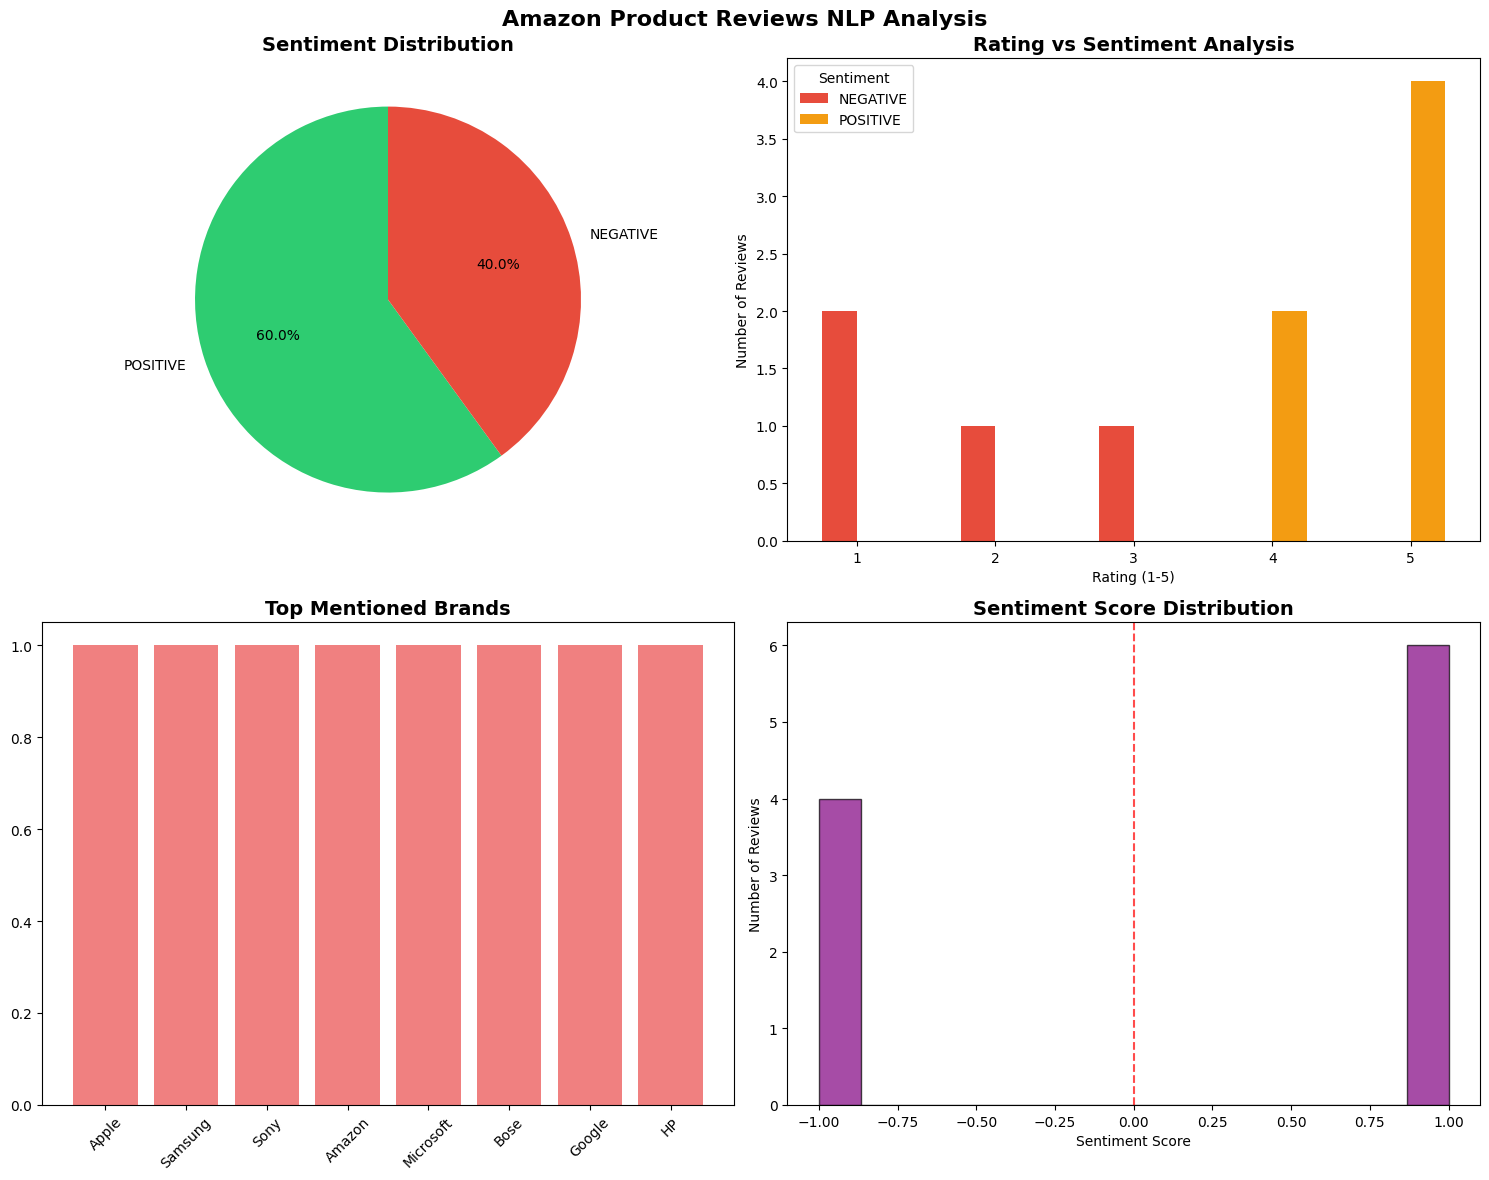


🔍 ENTITY-SENTIMENT CORRELATION:

Average Sentiment by Entity (Top 10):
  Apple: 1.000 (POSITIVE)
  iPhone: 1.000 (POSITIVE)
  Camera: 1.000 (POSITIVE)
  Samsung: -1.000 (NEGATIVE)
  Galaxy: -1.000 (NEGATIVE)
  Sony: 1.000 (POSITIVE)
  Amazon: -1.000 (NEGATIVE)
  Echo: -1.000 (NEGATIVE)
  Microsoft: 1.000 (POSITIVE)
  Surface: 1.000 (POSITIVE)


In [7]:
# Cell 7: Visualization of Amazon reviews analysis
def visualize_amazon_analysis(analyzed_df):
    """Create visualizations for Amazon reviews analysis"""
    
    print("\n📊 CREATING VISUALIZATIONS...")
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Amazon Product Reviews NLP Analysis', fontsize=16, fontweight='bold')
    
    # 1. Sentiment Distribution
    sentiment_counts = analyzed_df['sentiment'].value_counts()
    colors = ['#2ecc71', '#e74c3c', '#f39c12']  # Green, Red, Orange
    axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                   autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0, 0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
    
    # 2. Rating vs Sentiment
    rating_sentiment = pd.crosstab(analyzed_df['rating'], analyzed_df['sentiment'])
    rating_sentiment.plot(kind='bar', ax=axes[0, 1], color=['#e74c3c', '#f39c12', '#2ecc71'])
    axes[0, 1].set_title('Rating vs Sentiment Analysis', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Rating (1-5)')
    axes[0, 1].set_ylabel('Number of Reviews')
    axes[0, 1].legend(title='Sentiment')
    axes[0, 1].tick_params(axis='x', rotation=0)
    
    # 3. Top Brands Mentioned
    all_brands = [brand for sublist in analyzed_df['brands'] for brand in sublist]
    if all_brands:
        brand_counts = Counter(all_brands)
        brands, counts = zip(*brand_counts.most_common(8))
        axes[1, 0].bar(brands, counts, color='lightcoral')
        axes[1, 0].set_title('Top Mentioned Brands', fontsize=14, fontweight='bold')
        axes[1, 0].tick_params(axis='x', rotation=45)
    else:
        axes[1, 0].text(0.5, 0.5, 'No brands detected', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Top Mentioned Brands', fontsize=14, fontweight='bold')
    
    # 4. Sentiment Score Distribution
    axes[1, 1].hist(analyzed_df['sentiment_score'], bins=15, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Sentiment Score')
    axes[1, 1].set_ylabel('Number of Reviews')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
    
    plt.tight_layout()
    plt.show()
    
    # Entity-sentiment correlation
    print("\n🔍 ENTITY-SENTIMENT CORRELATION:")
    entity_sentiment = {}
    
    for idx, row in analyzed_df.iterrows():
        for brand in row['brands']:
            if brand not in entity_sentiment:
                entity_sentiment[brand] = []
            entity_sentiment[brand].append(row['sentiment_score'])
        
        for product in row['products']:
            if product not in entity_sentiment:
                entity_sentiment[product] = []
            entity_sentiment[product].append(row['sentiment_score'])
    
    print("\nAverage Sentiment by Entity (Top 10):")
    entity_sentiment_avg = {}
    for entity, scores in entity_sentiment.items():
        entity_sentiment_avg[entity] = np.mean(scores)
    
    for entity, avg_score in sorted(entity_sentiment_avg.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
        sentiment_label = "POSITIVE" if avg_score > 0.1 else "NEGATIVE" if avg_score < -0.1 else "NEUTRAL"
        print(f"  {entity}: {avg_score:.3f} ({sentiment_label})")

# Create visualizations
visualize_amazon_analysis(analyzed_df)

In [8]:
# Cell 8: Performance metrics and accuracy evaluation
def evaluate_amazon_analysis(analyzed_df):
    """Evaluate the performance of NER and sentiment analysis"""
    
    print("\n📊 PERFORMANCE METRICS")
    print("=" * 50)
    
    # Sentiment accuracy compared to ratings
    correct_predictions = 0
    total_reviews = len(analyzed_df)
    
    for idx, row in analyzed_df.iterrows():
        rating = row['rating']
        predicted_sentiment = row['sentiment']
        
        # Ground truth based on ratings
        if rating >= 4:
            true_sentiment = "POSITIVE"
        elif rating <= 2:
            true_sentiment = "NEGATIVE"
        else:
            true_sentiment = "NEUTRAL"
        
        if predicted_sentiment == true_sentiment:
            correct_predictions += 1
    
    accuracy = (correct_predictions / total_reviews) * 100
    
    print(f"Sentiment Analysis Accuracy: {accuracy:.1f}%")
    print(f"Correct predictions: {correct_predictions}/{total_reviews}")
    
    # Entity extraction metrics
    total_entities = 0
    entity_types = {}
    
    for idx, row in analyzed_df.iterrows():
        for entity_type, entities in row['all_entities'].items():
            if entity_type not in entity_types:
                entity_types[entity_type] = 0
            entity_types[entity_type] += len(entities)
            total_entities += len(entities)
    
    print(f"\nENTITY EXTRACTION METRICS:")
    print(f"Total Entities Extracted: {total_entities}")
    print(f"Average Entities per Review: {total_entities/total_reviews:.2f}")
    
    print(f"\nEntity Type Breakdown:")
    for entity_type, count in sorted(entity_types.items(), key=lambda x: x[1], reverse=True):
        if count > 0:
            percentage = (count / total_entities) * 100
            print(f"  {entity_type}: {count} ({percentage:.1f}%)")
    
    # Review length analysis
    analyzed_df['review_length'] = analyzed_df['review_text'].apply(len)
    avg_length = analyzed_df['review_length'].mean()
    
    print(f"\nREVIEW LENGTH ANALYSIS:")
    print(f"Average review length: {avg_length:.0f} characters")
    print(f"Shortest review: {analyzed_df['review_length'].min()} characters")
    print(f"Longest review: {analyzed_df['review_length'].max()} characters")

# Evaluate performance
evaluate_amazon_analysis(analyzed_df)


📊 PERFORMANCE METRICS
Sentiment Analysis Accuracy: 90.0%
Correct predictions: 9/10

ENTITY EXTRACTION METRICS:
Total Entities Extracted: 27
Average Entities per Review: 2.70

Entity Type Breakdown:
  PRODUCT: 11 (40.7%)
  BRAND: 10 (37.0%)
  ORG: 5 (18.5%)
  MONEY: 1 (3.7%)

REVIEW LENGTH ANALYSIS:
Average review length: 66 characters
Shortest review: 53 characters
Longest review: 79 characters
